# Stroke Prediction using ML

# Imports

Necessary Installations:

pip install imblearn

pip install xgboost

pip install scikit-learn

pip install tensorflow

Note- Restart kernel after installation

In [1]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Ignoring all warnings in the notebook
import warnings
warnings.simplefilter(action='ignore')

# Preprocessing

In [4]:
#Extracting the dataset in dataframe
df = pd.read_csv('https://raw.githubusercontent.com/Animesh352/StrokePredictionML/main/healthcare-dataset-stroke-data.csv')

In [5]:
# Print the dimensions of the dataset
print(df.shape)

(5110, 12)


In [6]:
# Preview the first 5 rows
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# Get the summary of variables
print(df.describe())

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

In [8]:
# Check for missing values in the DataFrame
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [9]:
#Dropping column 'id'
df = df.drop('id', axis=1)

In [10]:
# Replace missing values in the 'bmi' column with the mean values
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [11]:
# Drop rows with missing values in other columns
df.dropna(inplace=True)

In [12]:
#Preview the first 5 rows
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [13]:
#Get all the unique values from all categorical columns
print(df['gender'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Since, we have two categorical variables with two categories-'ever_married' and 'Residence_type', and others with more than two categories, we can only convert those two directly to numerical using binary values(0 and 1). Other categories can be converted to numerical format by using various methods of conversion. Here, we are going to use OneHotEncoder from sklearn.preprocessing to convert the three categorical columns to numerical.

In [14]:
# Convert categorical variable 'ever_married' to numerical format
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical variable 'Residence_type' to numerical format
df['Residence_type'] = df['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)

In [15]:
# Define the columns from the dataframe to be encoded
cols_to_encode = ['gender', 'work_type', 'smoking_status']

# Initialize the OneHotEncoder object as encoder
encoder = OneHotEncoder()

# Fit and transform the encoder on the selected columns
encoded_cols = encoder.fit_transform(df[cols_to_encode])

# Convert the encoded columns into a Pandas dataframe
encoded_cols_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(cols_to_encode))

# Drop the original categorical columns from the original dataframe
df = df.drop(columns=cols_to_encode)

# Concatenate the original dataframe with the encoded columns dataframe
df_encoded = pd.concat([df, encoded_cols_df], axis=1)

In [16]:
# Print the first 5 rows of the encoded dataframe
print(df_encoded.head())

    age  hypertension  heart_disease  ever_married  Residence_type  \
0  67.0             0              1             1               1   
1  61.0             0              0             1               0   
2  80.0             0              1             1               0   
3  49.0             0              0             1               1   
4  79.0             1              0             1               0   

   avg_glucose_level        bmi  stroke  gender_Female  gender_Male  \
0             228.69  36.600000       1            0.0          1.0   
1             202.21  28.893237       1            1.0          0.0   
2             105.92  32.500000       1            0.0          1.0   
3             171.23  34.400000       1            1.0          0.0   
4             174.12  24.000000       1            1.0          0.0   

   gender_Other  work_type_Govt_job  work_type_Never_worked  \
0           0.0                 0.0                     0.0   
1           0.0           

Now we need to check for important columns in our dataset which have a high number of outliers. We will transform the 'bmi' and 'avg_glucose_level' columns.

<AxesSubplot:xlabel='bmi'>

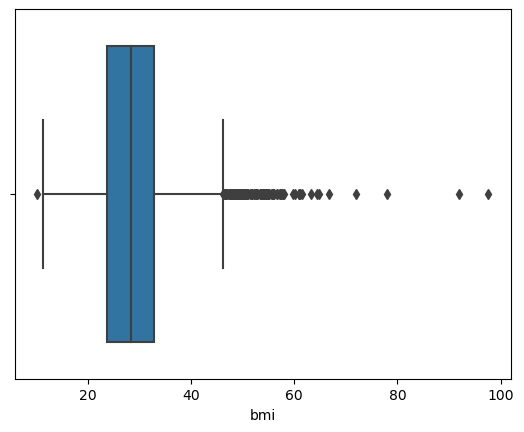

In [17]:
# Check for outliers in the 'bmi' column using a boxplot
sns.boxplot(x=df_encoded['bmi'])

In [18]:
# Remove outliers in the 'bmi' column
q1 = df_encoded['bmi'].quantile(0.25)
q3 = df_encoded['bmi'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_encoded = df_encoded[(df_encoded['bmi'] >= lower) & (df_encoded['bmi'] <= upper)]

<AxesSubplot:xlabel='bmi'>

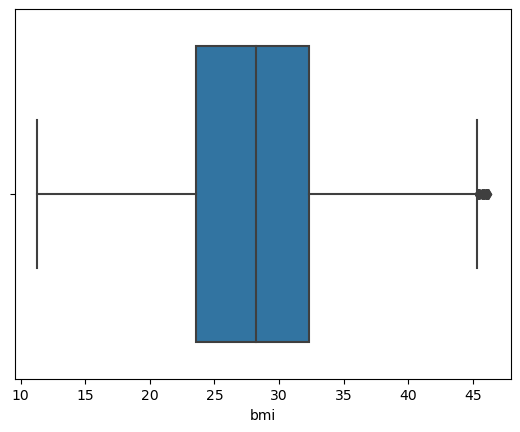

In [19]:
#Replot the column to observe the changes
sns.boxplot(x=df_encoded['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

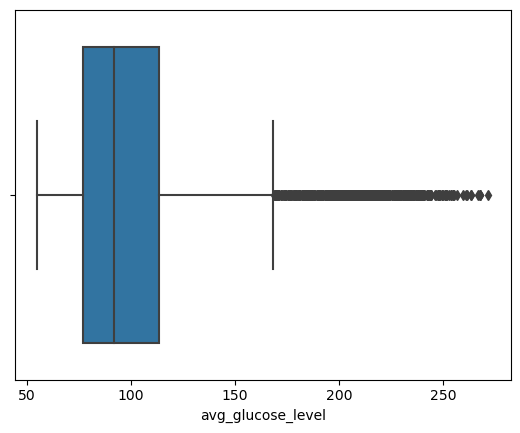

In [20]:
# Check for outliers in the 'avg_glucose_level' column using a boxplot
sns.boxplot(x=df_encoded['avg_glucose_level'])

In [21]:
# Remove outliers in the 'avg_glucose_level' column
q1 = df_encoded['avg_glucose_level'].quantile(0.25)
q3 = df_encoded['avg_glucose_level'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_encoded = df_encoded[(df_encoded['avg_glucose_level'] >= lower) & (df_encoded['avg_glucose_level'] <= upper)]

<AxesSubplot:xlabel='avg_glucose_level'>

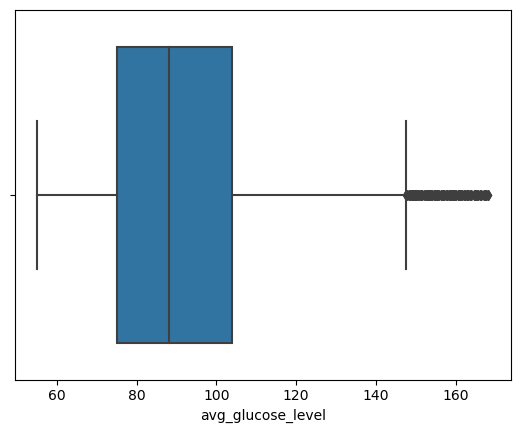

In [22]:
#Replot the column to observe the changes
sns.boxplot(x=df_encoded['avg_glucose_level'])

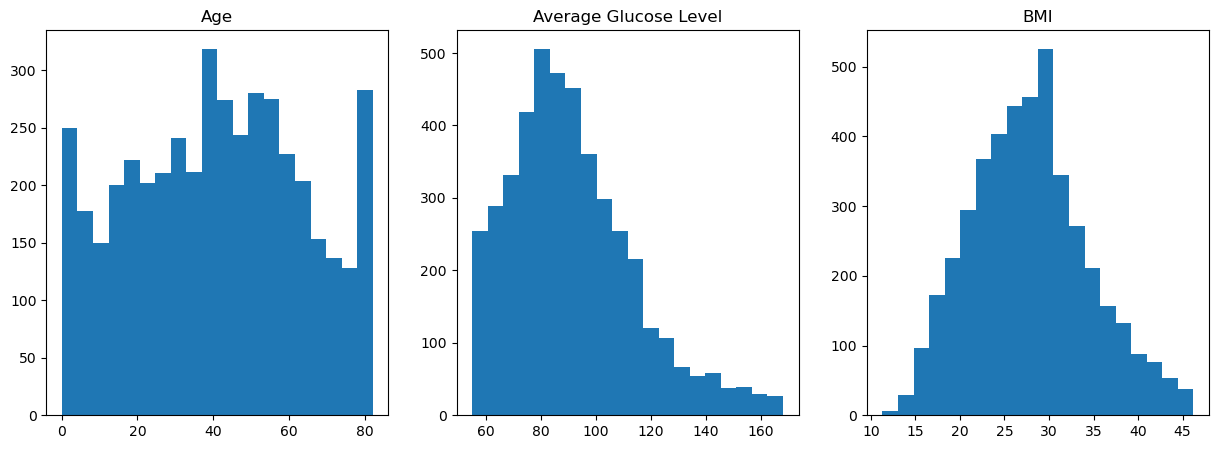

In [23]:
# Plot the histograms of the three original numerical columns to visualize their distributions
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(df_encoded['age'], bins=20)
ax[0].set_title('Age')
ax[1].hist(df_encoded['avg_glucose_level'], bins=20)
ax[1].set_title('Average Glucose Level')
ax[2].hist(df_encoded['bmi'], bins=20)
ax[2].set_title('BMI')
plt.show()

In [24]:
# Normalize the columns using z-score normalization
scaler = StandardScaler()
df_encoded[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df_encoded[['age', 'avg_glucose_level', 'bmi']])

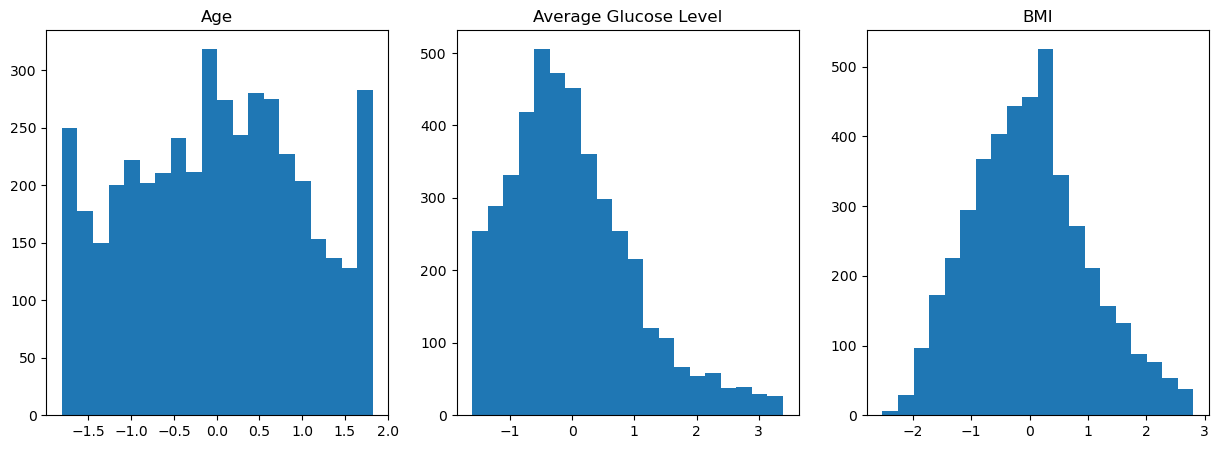

In [25]:
# Plot the histograms of the columns to visualize their normalization
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(df_encoded['age'], bins=20)
ax[0].set_title('Age')
ax[1].hist(df_encoded['avg_glucose_level'], bins=20)
ax[1].set_title('Average Glucose Level')
ax[2].hist(df_encoded['bmi'], bins=20)
ax[2].set_title('BMI')
plt.show()

In [26]:
# Summary of normalized variables
print(df_encoded[['age', 'avg_glucose_level', 'bmi']].describe())

                age  avg_glucose_level           bmi
count  4.390000e+03       4.390000e+03  4.390000e+03
mean  -1.559433e-16      -1.393216e-16  7.017925e-18
std    1.000114e+00       1.000114e+00  1.000114e+00
min   -1.810742e+00      -1.605635e+00 -2.516404e+00
25%   -7.937121e-01      -7.240477e-01 -7.029061e-01
50%    4.937513e-02      -1.510874e-01 -2.474950e-02
75%    7.593433e-01       5.547572e-01  6.229282e-01
max    1.824296e+00       3.388519e+00  2.802173e+00


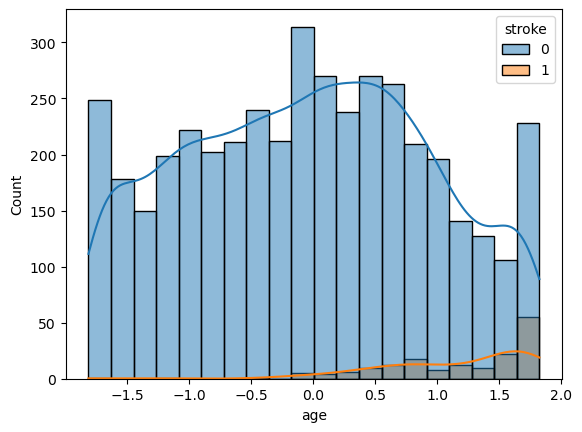

In [27]:
# Histogram of age with stroke results
sns.histplot(data=df_encoded, x='age', hue='stroke', kde=True)
plt.show()

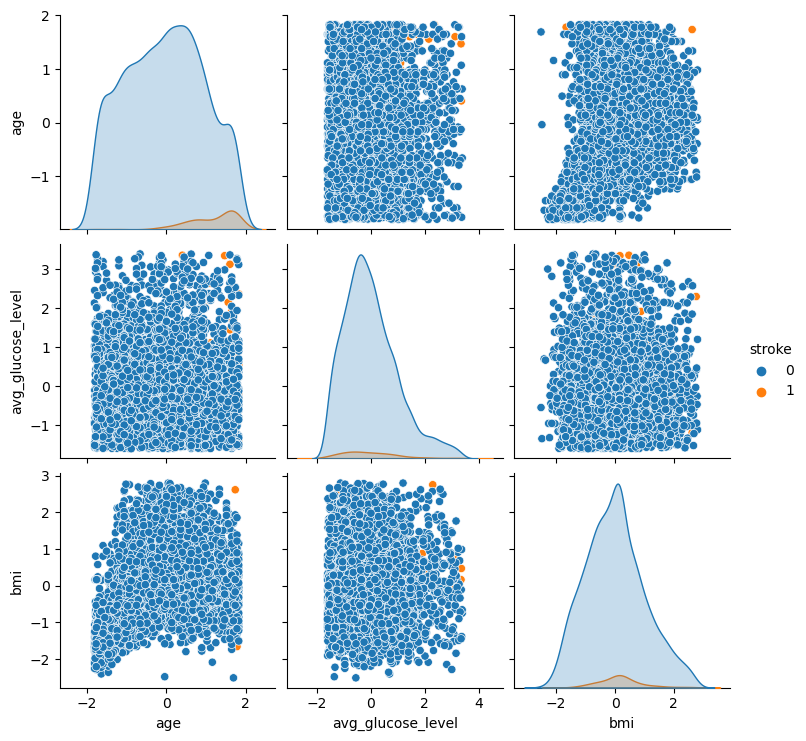

In [28]:
# Scatterplot matrix of age, avg_glucose_level, and bmi
sns.pairplot(data=df_encoded, vars=['age', 'avg_glucose_level', 'bmi'], hue='stroke')
plt.show()

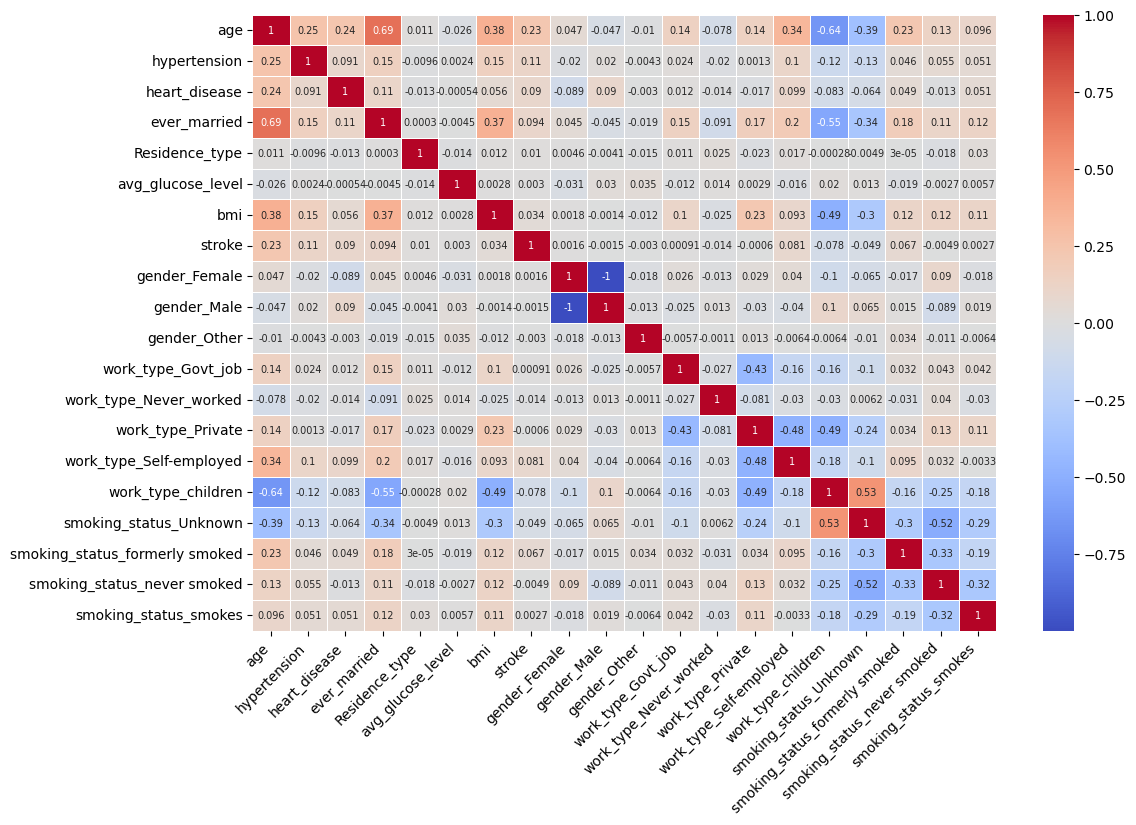

In [29]:
# Correlation matrix of dimensions

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap with annotations
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', linewidths=.5, ax=ax, annot_kws={"fontsize": 7})

# Rotate the x-axis labels for better readability of the heatmap
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

<AxesSubplot:xlabel='stroke', ylabel='count'>

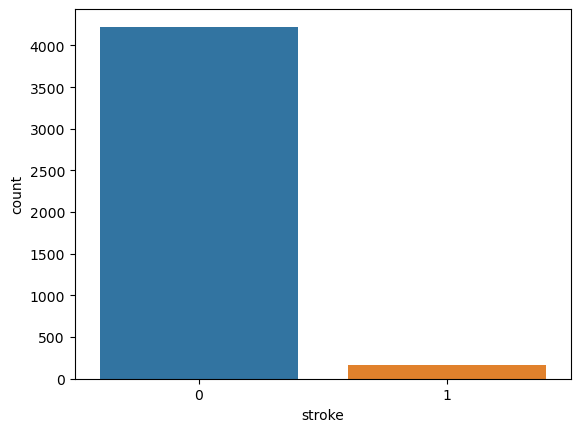

In [30]:
# Plot the distribution of the outcome variable(stroke)
sns.countplot(x='stroke', data=df_encoded)

In [31]:
# Separate features and target variable from the dataframe
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

In [32]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SMOTE for Balancing the dataset

Since we know that our dataset is imbalanced, we need to balance the dataset in order to fit it on our models to prevent bias. We will do this by oversampling the minority class of our dataset using SMOTE(Synthetic Minority Oversampling Technique). However, we will only balance the training data, as balancing the test set may lead to overfitting.

In [33]:
# Apply SMOTE to balance the dataset
oversampler = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = oversampler.fit_resample(X_train, y_train)

Use X_train_SMOTE, y_train_SMOTE for implementation with SMOTE.

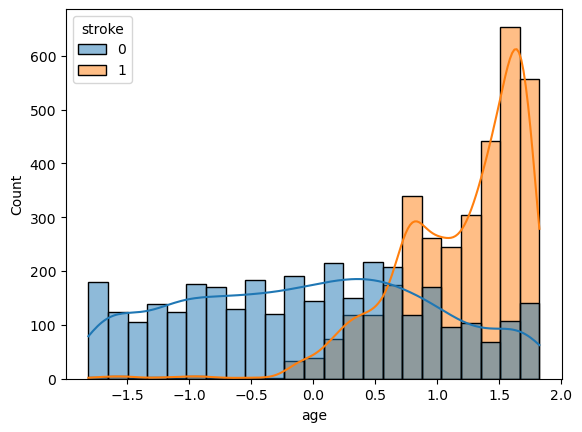

In [34]:
#Plot the outcomes from the balanced training dataset w.r.t. age
sns.histplot(data=X_train_SMOTE, x='age', hue=y_train_SMOTE, kde=True)
plt.show()

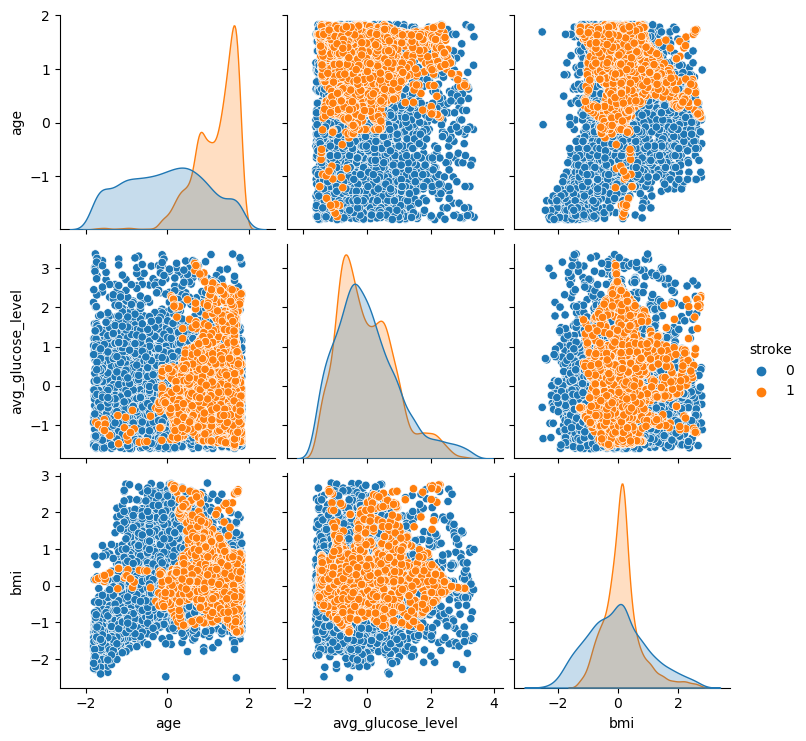

In [35]:
# Scatterplot matrix of age, avg_glucose_level, and bmi from the balanced training set
scatterplot_df = pd.concat([X_train_SMOTE, y_train_SMOTE], axis=1)
sns.pairplot(data=scatterplot_df, vars=['age', 'avg_glucose_level', 'bmi'], hue='stroke')
plt.show()

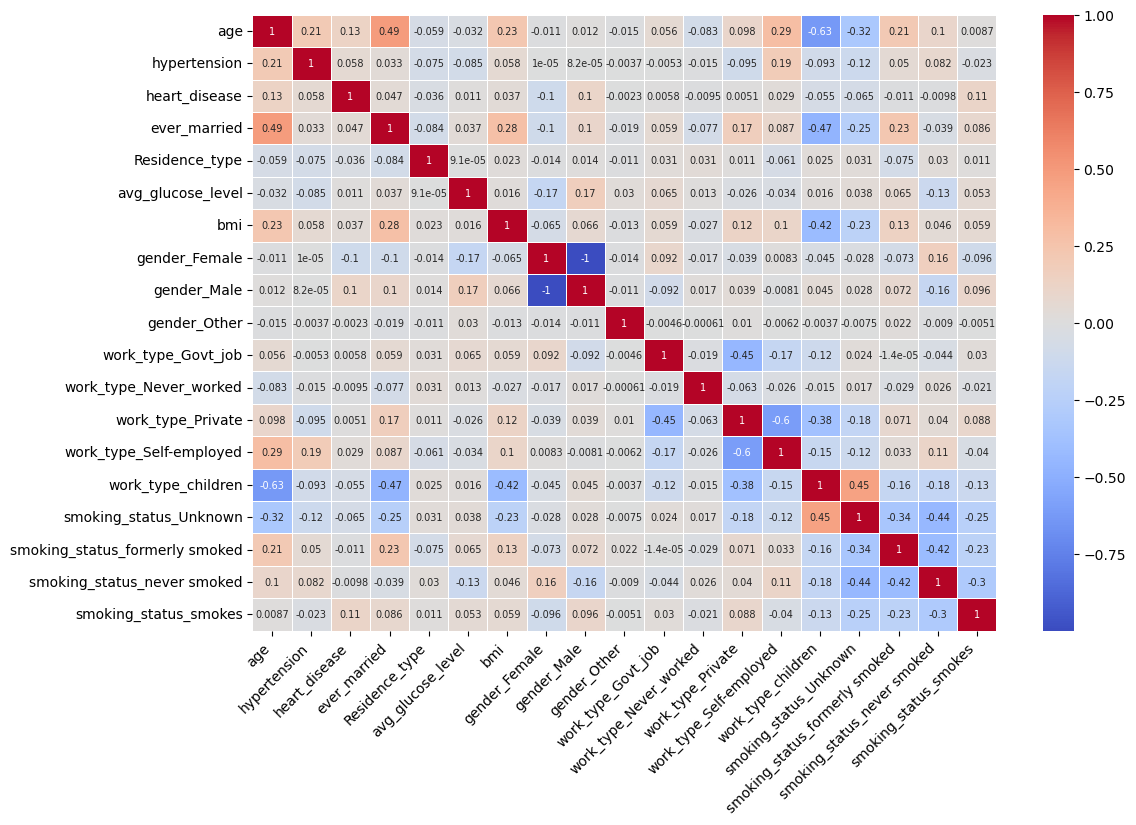

In [36]:
# Correlation matrix of dimensions

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap with annotations for the balanced set
sns.heatmap(X_train_SMOTE.corr(), annot=True, cmap='coolwarm', linewidths=.5, ax=ax, annot_kws={"fontsize": 7})

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

# Implementation of Algorithms on the Dataset with Hyperparameter Tuning

We are tuning the important hyperparameters for all our models in order to get the best possible accuracy. Also, we have used the parameters we received through grid search and built a new optimized model for each algorithm. There is a minimal probability that the best possible parameters received after running the cells below might differ from the one used to build our models.

Although we cover different performance metrics for all the models, our main objective here is to obtain the ROC-AUC score of all models and plot them to understand how well each model performs. AUC - ROC curve is a performance measurement for binary classification problems at various threshold settings. The ROC curve is a graphical representation of a model's performance at different classification thresholds, while AUC is a single metric that summarizes the model's overall performance across all thresholds.

AUC ranges from 0 to 1, with a perfect model having an AUC of 1 and a random model having an AUC of 0.5.

Another important metric is the general model accuracy which we are also using to compare all the models.

# XGBoost Model

## On Imbalanced Dataset

In [37]:
# Define a dictionary of hyperparameters
# and GridSearchCV will search the combinations

xgb_params = {'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.001, 0.01, 0.1],
              'n_estimators': [25, 50, 100, 150]}

In [38]:
xgb_model_imb = xgb.XGBClassifier(use_label_encoder =False, random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model_imb, xgb_params, cv=5)
grid_search.fit(X_train, y_train)

#Return the best possible parameters from the given dictionary and also the best accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best accuracy: 0.9635538372380477


In [39]:
#Run the xgboost model using those hyperparameters
xgb_model_imb = xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_model_imb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [40]:
#Get the prediction on test set and get all the scoring metrics
y_pred = xgb_model_imb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('F1 score:', f1)
print('ROC-AUC score:', roc_auc)
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

F1 score: 0.0
ROC-AUC score: 0.4994061757719715
Precision: 0.0
Recall: 0.0
Accuracy: 0.9578587699316629


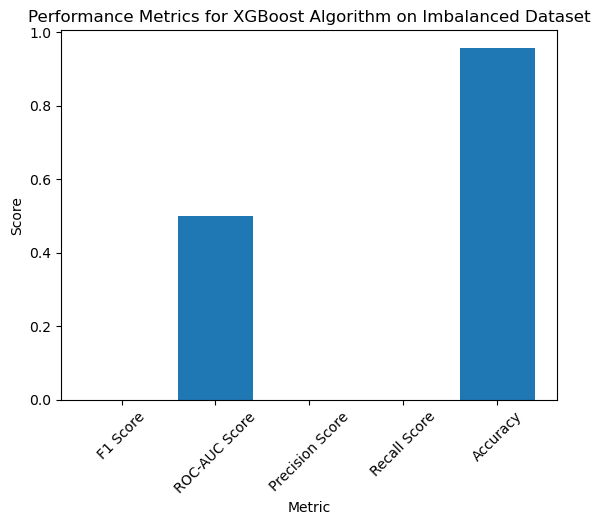

In [41]:
#Create a plot for the scoring metrics

# Define the metric names and scores
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.0, 0.4994, 0.0, 0.0, 0.9578]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for XGBoost Algorithm on Imbalanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation = 45)

# Display the plot
plt.show()

In [42]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       842
           1       0.00      0.00      0.00        36

    accuracy                           0.96       878
   macro avg       0.48      0.50      0.49       878
weighted avg       0.92      0.96      0.94       878



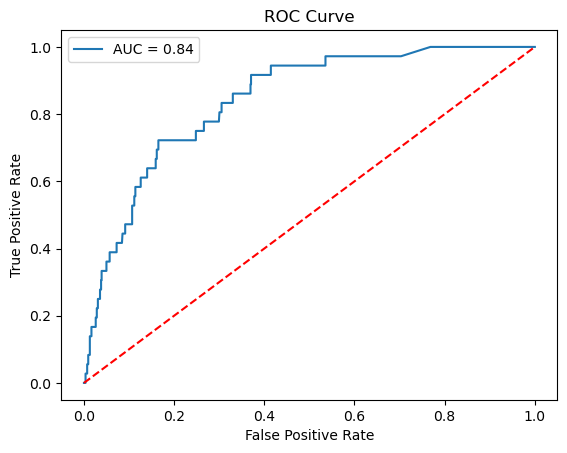

In [43]:
# An ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) 
# It evaluates performance of the model at different classification thresholds

# Use the xgb_model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = xgb_model_imb.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

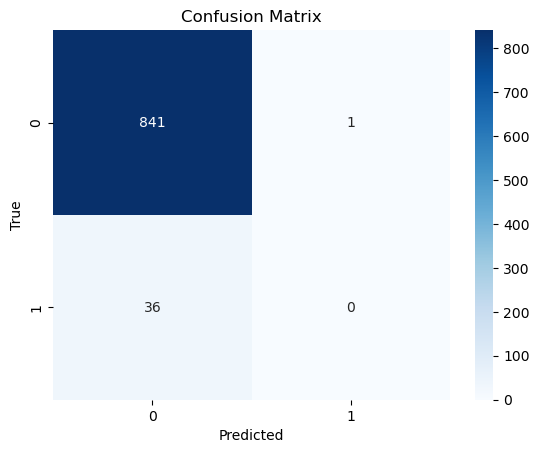

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

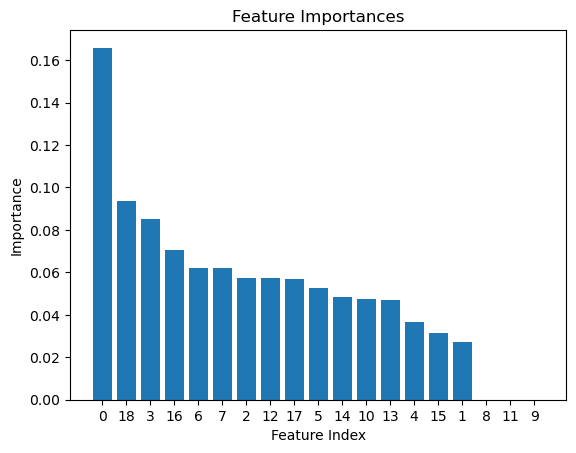

In [45]:
# Feature importances represent the contribution of each feature to the model's predictions

# Import the feature importances from an XGBoost model
importances = xgb_model_imb.feature_importances_

# Sort the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar plot of the feature importances
plt.bar(range(X_train.shape[1]), importances[indices])

# Label the x-axis with the indices of the features
plt.xticks(range(X_train.shape[1]), indices)

# Label the x- and y-axes with descriptive text
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances")

# Display the plot
plt.show()

## On Balanced Dataset

In [46]:
#Get the best parameters for xgboost classifier model based on the balanced training dataset
xgb_model_b = xgb.XGBClassifier(use_label_encoder =False, random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model_b, xgb_params, cv=5)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Best accuracy: 0.9527086260522871


In [47]:
#Run the model using the above hyperparamaters
xgb_model_b = xgb.XGBClassifier(max_depth=5, n_estimators=150, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_model_b.fit(X_train_SMOTE, y_train_SMOTE)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [48]:
#Get the predictions and performance metrics for the test set
y_pred = xgb_model_b.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('F1 score:', f1)
print('ROC-AUC score:', roc_auc)
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

F1 score: 0.14678899082568808
ROC-AUC score: 0.5725125362892584
Precision: 0.1095890410958904
Recall: 0.2222222222222222
Accuracy: 0.8940774487471527


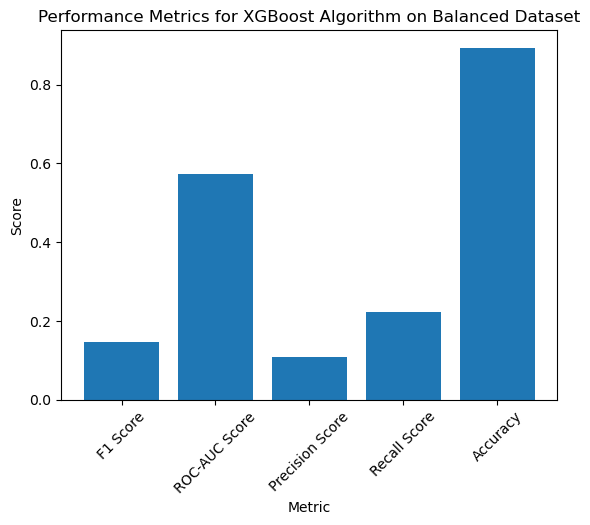

In [49]:
#Plot the obtained metrics
# Define the metric names and scores
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.1467, 0.5725, 0.1095, 0.2222, 0.8940]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for XGBoost Algorithm on Balanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation = 45)

# Display the plot
plt.show()

In [50]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       842
           1       0.11      0.22      0.15        36

    accuracy                           0.89       878
   macro avg       0.54      0.57      0.55       878
weighted avg       0.93      0.89      0.91       878



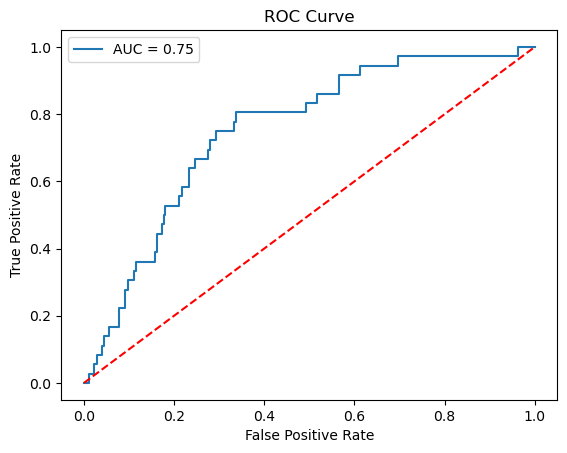

In [51]:
# Use the xgb_model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = xgb_model_b.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

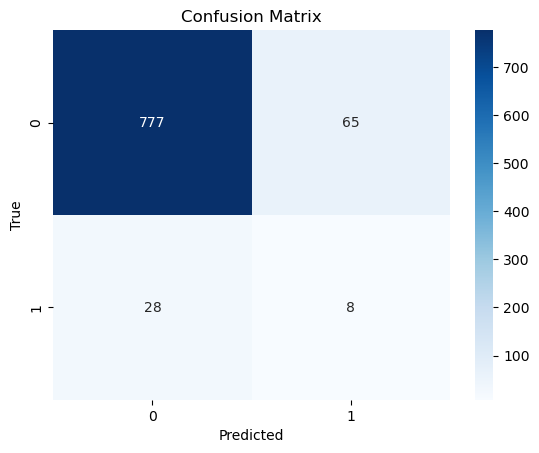

In [52]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

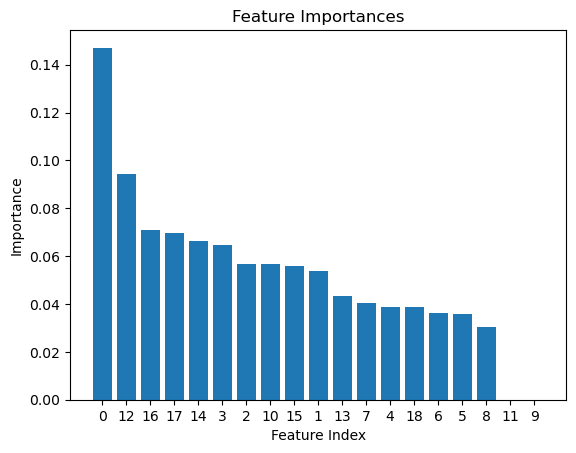

In [53]:
# Feature importances represent the contribution of each feature to the model's predictions from the balanced dataset

# Import the feature importances from an XGBoost model
importances = xgb_model_b.feature_importances_

# Sort the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar plot of the feature importances
plt.bar(range(X_train.shape[1]), importances[indices])

# Label the x-axis with the indices of the features
plt.xticks(range(X_train.shape[1]), indices)

# Label the x- and y-axes with descriptive text
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances")

# Display the plot
plt.show()

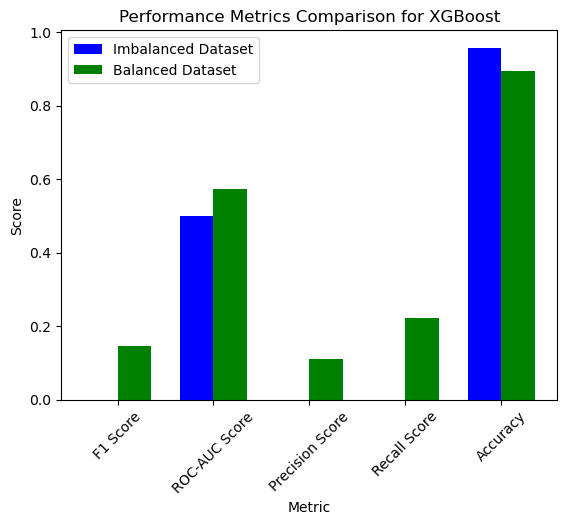

In [54]:
# Define the metric names and scores for the imbalanced dataset
metric_names_imbalanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_imbalanced = [0.0, 0.4994, 0.0, 0.0, 0.9578]

# Define the metric names and scores for the balanced data
metric_names_balanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_balanced = [0.1467, 0.5725, 0.1095, 0.2222, 0.8940]

# Create a bar plot
bar_width = 0.35
r1 = np.arange(len(metric_scores_imbalanced))
r2 = [x + bar_width for x in r1]
plt.bar(r1, metric_scores_imbalanced, color='b', width=bar_width, label='Imbalanced Dataset')
plt.bar(r2, metric_scores_balanced, color='g', width=bar_width, label='Balanced Dataset')

# Set the title and axis labels
plt.title('Performance Metrics Comparison for XGBoost')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks([r + bar_width/2 for r in range(len(metric_scores_imbalanced))], metric_names_imbalanced, rotation = 45)

# Add a legend
plt.legend()

# Display the plot
plt.show()

## Logistic Regression 

In order to prevent convergence of our logistic regression, we have set the max_iterations value to 5000.

## On Imbalanced Dataset

In [55]:
# Define the parameter grid for hyperparameter tuning
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'solver': ['liblinear', 'saga', 'newton']}

In [56]:
# Perform grid search cross validation to find the best hyperparameters for the imbalanced data
lr = LogisticRegression(random_state=42, max_iter = 5000)
grid_search = GridSearchCV(lr, param_grid=lr_param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best hyperparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.0


In [57]:
#Run the logistic regression model using the hyperparameters obtained above
lr_imb = LogisticRegression(random_state=42, max_iter = 5000, C = 0.01, penalty = 'l1', solver = 'liblinear')
lr_imb.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

In [58]:
# Make predictions on the test set
y_pred = lr_imb.predict(X_test)

In [59]:
# Compute the required scores using the predictions obtained
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [60]:
# Print the scores
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("Accuracy:", accuracy)

F1 Score:  0.0
ROC-AUC Score:  0.5
Precision Score:  0.0
Recall Score:  0.0
Accuracy: 0.958997722095672


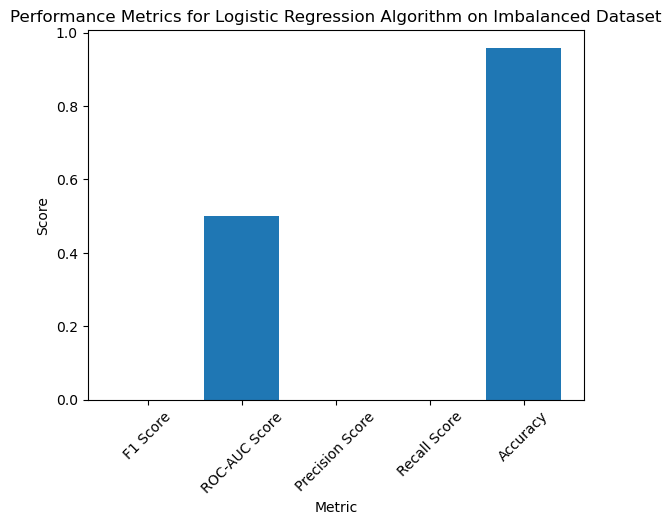

In [61]:
# Define the metric names and scores from the above model
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.0, 0.5, 0.0, 0.0, 0.9589]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for Logistic Regression Algorithm on Imbalanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')

#Set the values on x-scale to rotate for 45 degrees to prevent overlaping
plt.xticks(rotation = 45)

# Display the plot
plt.show()

In [62]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       842
           1       0.00      0.00      0.00        36

    accuracy                           0.96       878
   macro avg       0.48      0.50      0.49       878
weighted avg       0.92      0.96      0.94       878



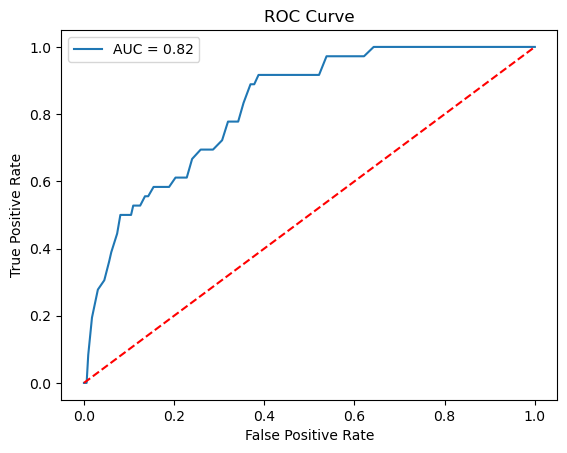

In [63]:
# An ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) 
# It evaluates performance of the model at different classification thresholds

# Use the logistic regression model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = grid_search.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

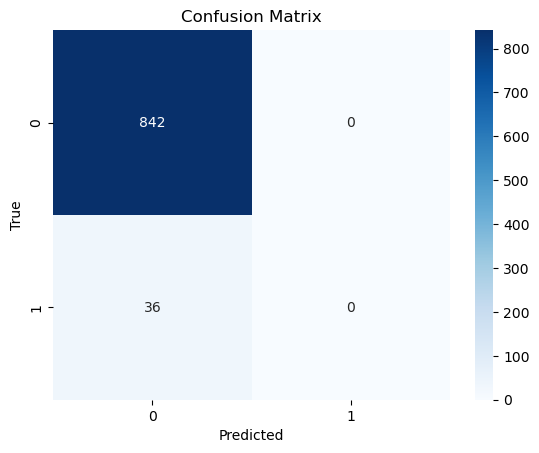

In [64]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We can observe that the logistic regression model is very bad in predicting the outcome on imbalanced dataset. Now, we would try fitting the model with balanced dataset to compare the results.

## On Balanced Dataset 

In [65]:
# Perform grid search to find the best hyperparameters for the balanced dataset
lr = LogisticRegression(random_state=42, max_iter = 5000)
grid_search = GridSearchCV(lr, param_grid=lr_param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)
# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best hyperparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 0.8170926437154051


In [66]:
lr_b = LogisticRegression(random_state=42, max_iter = 5000, C = 0.01, penalty = 'l2', solver = 'liblinear')
lr_b.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression(C=0.01, max_iter=5000, random_state=42, solver='liblinear')

In [67]:
# Make predictions on the test set
y_pred = lr_b.predict(X_test)

In [68]:
# Compute the required scores using the predictions obtained
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [69]:
# Print the scores for the model with balanced dataset
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("Accuracy:", accuracy)

F1 Score:  0.17454545454545453
ROC-AUC Score:  0.705661124307205
Precision Score:  0.100418410041841
Recall Score:  0.6666666666666666
Accuracy: 0.7414578587699316


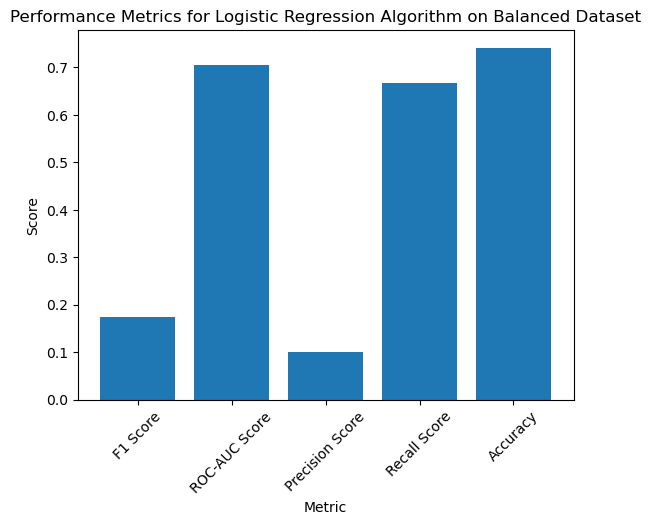

In [70]:
# Define the metric names and scores for the above model
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.1745, 0.7056, 0.1004, 0.6666, 0.7414]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for Logistic Regression Algorithm on Balanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation = 45)

# Display the plot
plt.show()

In [71]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.85       842
           1       0.10      0.67      0.17        36

    accuracy                           0.74       878
   macro avg       0.54      0.71      0.51       878
weighted avg       0.95      0.74      0.82       878



In [72]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.705661124307205


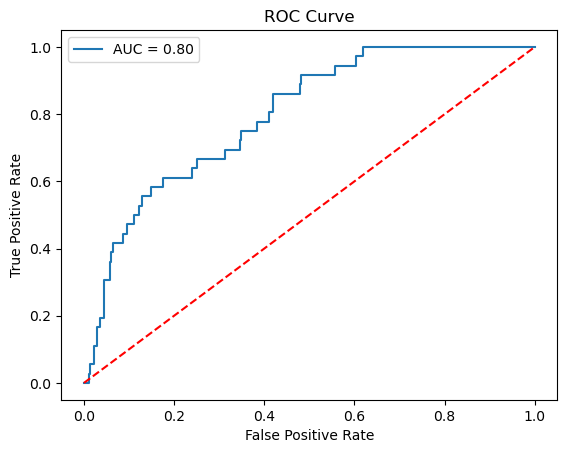

In [73]:
# An ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) 
# It evaluates performance of the model at different classification thresholds

# Use the logistic regression model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = grid_search.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

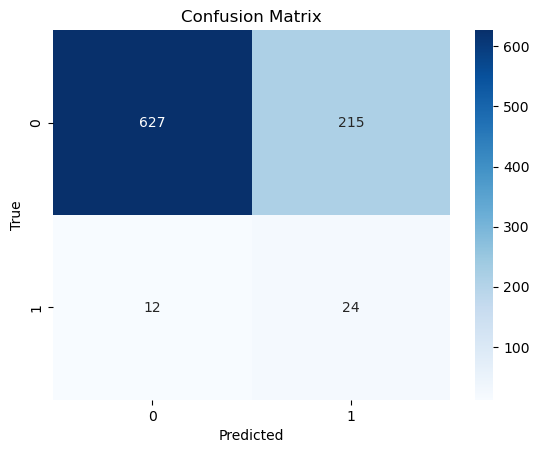

In [74]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

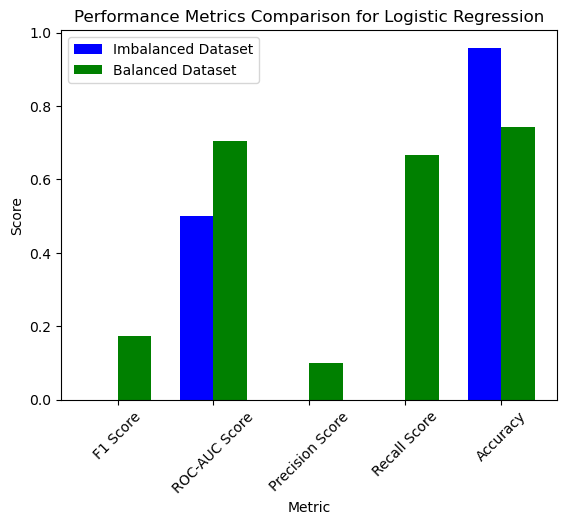

In [75]:
# Define the metric names and scores for the model with imbalanced dataset
metric_names_imbalanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_imbalanced = [0.0, 0.5, 0.0, 0.0, 0.9589]

# Define the metric names and scores for the model with balanced dataset
metric_names_balanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_balanced = [0.1745, 0.7056, 0.1004, 0.6666, 0.7414]

# Create a bar plot
bar_width = 0.35
r1 = np.arange(len(metric_scores_imbalanced))
r2 = [x + bar_width for x in r1]
plt.bar(r1, metric_scores_imbalanced, color='b', width=bar_width, label='Imbalanced Dataset')
plt.bar(r2, metric_scores_balanced, color='g', width=bar_width, label='Balanced Dataset')

# Set the title and axis labels
plt.title('Performance Metrics Comparison for Logistic Regression')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks([r + bar_width/2 for r in range(len(metric_scores_imbalanced))], metric_names_imbalanced, rotation = 45)

# Add a legend
plt.legend()

# Display the plot
plt.show()

## Naive Bayes

## On Imbalanced Dataset

In [76]:
# Create a Naive Bayes classifier
nb = GaussianNB()

# Define the hyperparameters to tune
#Here, we are only tuning the var_smoothing hyperparameter as Naive Bayes has very few hyperparameters to tune
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Use GridSearchCV to find the best hyperparameters
nb_cv = GridSearchCV(nb, param_grid, cv=5)
nb_cv.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", nb_cv.best_params_)
print("Best Accuracy:", nb_cv.best_score_)

Best Hyperparameters: {'var_smoothing': 1e-05}
Best Accuracy: 0.523363444416076


In [77]:
#Use the obtained hyperparameter value to build the model and train it using the imbalanced dataset
nb_imb = GaussianNB(var_smoothing = 1e-05)
nb_imb.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [78]:
# Make predictions on the test set
y_pred = nb_imb.predict(X_test)

In [79]:
# Compute the required scores for the above model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [80]:
# Print the scores
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("Accuracy: ", accuracy)

F1 Score:  0.12915851272015655
ROC-AUC Score:  0.6958630245447347
Precision Score:  0.06947368421052631
Recall Score:  0.9166666666666666
Accuracy:  0.49316628701594534


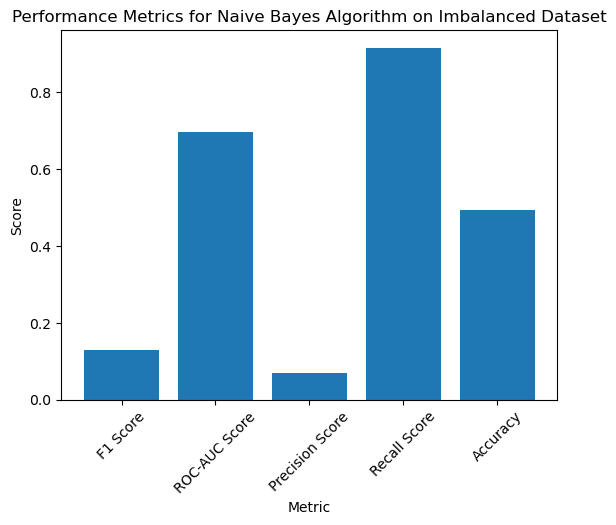

In [81]:
#Plot the scores obtained
# Define the metric names and scores
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.1291, 0.6958, 0.0694, 0.9166, 0.4931]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for Naive Bayes Algorithm on Imbalanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation = 45)
# Display the plot
plt.show()

In [82]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.48      0.64       842
           1       0.07      0.92      0.13        36

    accuracy                           0.49       878
   macro avg       0.53      0.70      0.39       878
weighted avg       0.95      0.49      0.62       878



In [83]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6958630245447347


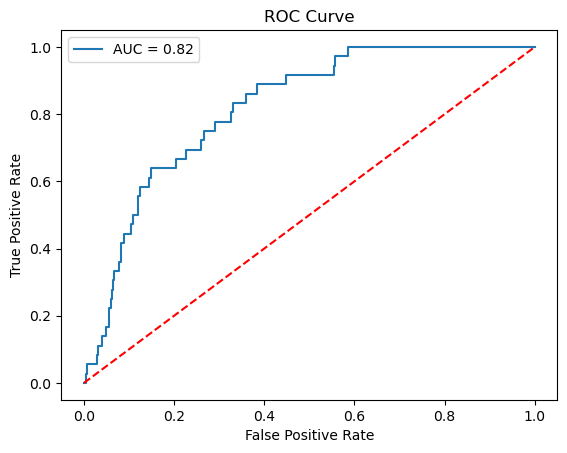

In [84]:
# An ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) 
# It evaluates performance of the model at different classification thresholds

# Use the Naive Bayes model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = nb_imb.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

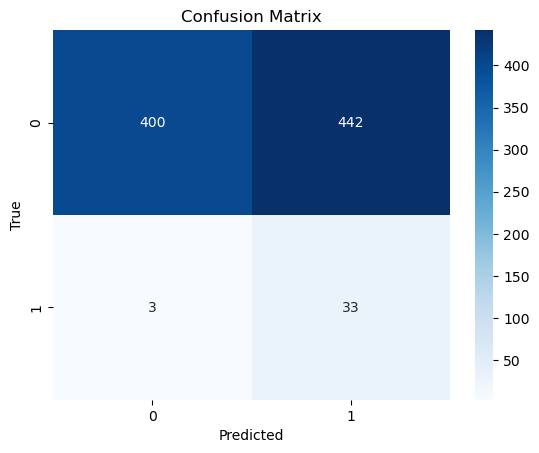

In [85]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## On Balanced Dataset 

In [86]:
# Create a Naive Bayes classifier
nb = GaussianNB()

# Define the hyperparameters to tune
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Use GridSearchCV to find the best hyperparameters
nb_b = GridSearchCV(nb, param_grid, cv=5)
nb_b.fit(X_train_SMOTE, y_train_SMOTE)

# Print the best hyperparameters
print("Best Hyperparameters:", nb_b.best_params_)
print("Best Accuracy:", nb_b.best_score_)

Best Hyperparameters: {'var_smoothing': 1e-05}
Best Accuracy: 0.6596224157487983


In [87]:
#Use the obtained hyperparameter value and build a model by fitting the balanced dataset
nb_b = GaussianNB(var_smoothing = 1e-05)
nb_b.fit(X_train_SMOTE, y_train_SMOTE)

GaussianNB(var_smoothing=1e-05)

In [88]:
# Make predictions on the test set
y_pred = nb_b.predict(X_test)

In [89]:
# Compute the required scores for the above model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [90]:
# Print the scores
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)
print("Precision Score: ", precision)
print("Recall Score: ", recall)
print("Accuracy:", accuracy)

F1 Score:  0.10892586989409983
ROC-AUC Score:  0.6502375296912114
Precision Score:  0.0576
Recall Score:  1.0
Accuracy: 0.32915717539863326


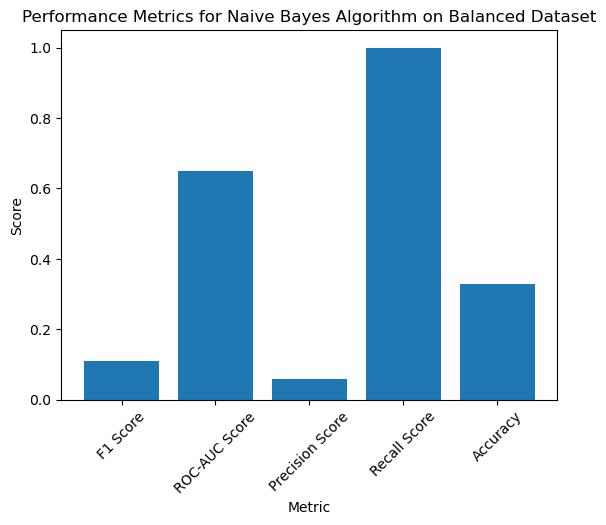

In [91]:
#Plot the obtained scores
# Define the metric names and scores
metric_names = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores = [0.1089, 0.6502, 0.0576, 1.0, 0.3291]

# Create a bar plot
plt.bar(metric_names, metric_scores)

# Set the title and axis labels
plt.title('Performance Metrics for Naive Bayes Algorithm on Balanced Dataset')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation = 45)
# Display the plot
plt.show()

In [92]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.30      0.46       842
           1       0.06      1.00      0.11        36

    accuracy                           0.33       878
   macro avg       0.53      0.65      0.29       878
weighted avg       0.96      0.33      0.45       878



In [93]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6502375296912114


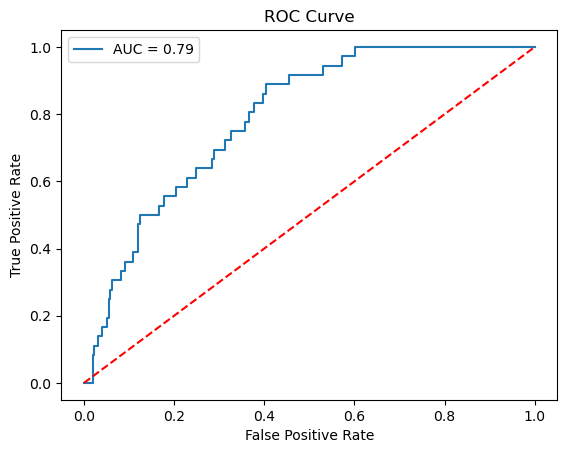

In [94]:
# An ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) 
# It evaluates performance of the model at different classification thresholds

# Use the Naive Bayes model to predict the probability of the test set classes
# y_scores will be a 1D array with n_samples elements, each element representing the predicted 
# probability of the corresponding instance belonging to the positive class.
y_scores = nb_b.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate, True Positive Rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute the Area Under the ROC Curve
auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve using the FPR and TPR values, and label the plot with the AUC value
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'r--')

# Set the X and Y axis labels and the plot title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

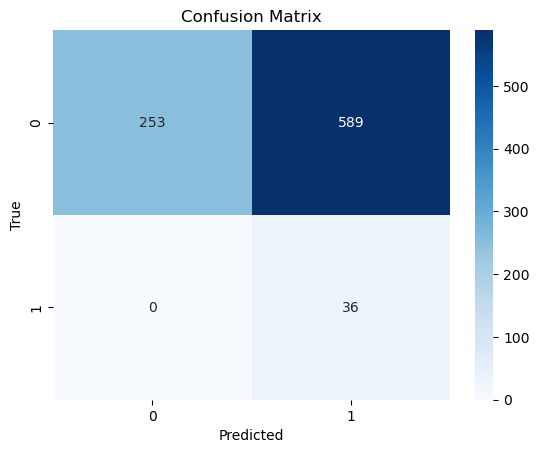

In [95]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

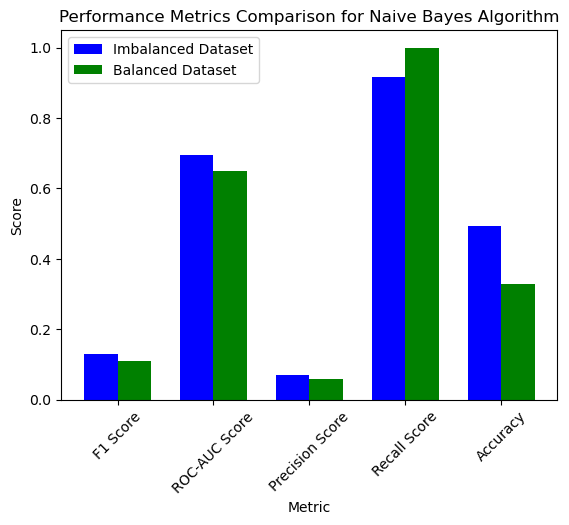

In [96]:
# Define the metric names and scores for the model with imbalanced dataset
metric_names_imbalanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_imbalanced = [0.1291, 0.6958, 0.0694, 0.9166, 0.4931]

# Define the metric names and scores for the model with balanced dataset
metric_names_balanced = ['F1 Score', 'ROC-AUC Score', 'Precision Score', 'Recall Score', 'Accuracy']
metric_scores_balanced = [0.1089, 0.6502, 0.0576, 1.0, 0.3291]

# Create a bar plot
bar_width = 0.35
r1 = np.arange(len(metric_scores_imbalanced))
r2 = [x + bar_width for x in r1]
plt.bar(r1, metric_scores_imbalanced, color='b', width=bar_width, label='Imbalanced Dataset')
plt.bar(r2, metric_scores_balanced, color='g', width=bar_width, label='Balanced Dataset')

# Set the title and axis labels
plt.title('Performance Metrics Comparison for Naive Bayes Algorithm')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks([r + bar_width/2 for r in range(len(metric_scores_imbalanced))], metric_names_imbalanced, rotation = 45)

# Add a legend
plt.legend()

# Display the plot
plt.show()

### Plot the performance metrics for all three algorithms and compare

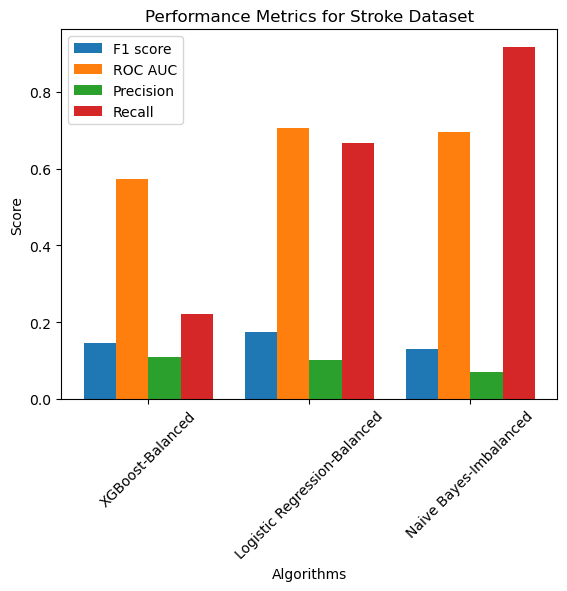

In [97]:
# Define all the algorithms and metrics
algorithms = ['XGBoost-Balanced', 'Logistic Regression-Balanced', 'Naive Bayes-Imbalanced']
metrics = ['F1 score', 'ROC AUC', 'Precision', 'Recall', 'Accuracy']

# Define the scores for each algorithm and metric
f1_scores = [0.1467, 0.1745, 0.1291]
roc_auc_scores = [0.5725, 0.7056, 0.6958]
precision_scores = [0.1095, 0.1004, 0.0694]
recall_scores = [0.2222, 0.6666, 0.9166]
accuracy = [0.8940, 0.7414, 0.4931]
# Set the width of the bars
bar_width = 0.2

# Define the x-axis ticks and position of each bar
x_ticks = np.arange(len(algorithms))
f1_pos = x_ticks
roc_auc_pos = x_ticks + bar_width
precision_pos = x_ticks + 2 * bar_width
recall_pos = x_ticks + 3 * bar_width

# Plot the bar chart
plt.bar(f1_pos, f1_scores, width=bar_width, label='F1 score')
plt.bar(roc_auc_pos, roc_auc_scores, width=bar_width, label='ROC AUC')
plt.bar(precision_pos, precision_scores, width=bar_width, label='Precision')
plt.bar(recall_pos, recall_scores, width=bar_width, label='Recall')

# Add axis labels and title
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics for Stroke Dataset')

# Add the x-axis ticks and legend
plt.xticks(x_ticks + 1.5*bar_width, algorithms, rotation = 45)
plt.legend()

# Display the plot
plt.show()

## Neural Network Model using Keras

We will implement a Deep Neural Network model on our imbalanced dataset. The reason for not using the balanced dataset is that neural models are not biased due to imbalance in the dataset.

In [98]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary cross entropy
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/50
88/88 [==============================] - 2s 6ms/step - loss: 0.3638 - accuracy: 0.8608 - val_loss: 0.1556 - val_accuracy: 0.9630
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9626 - val_loss: 0.1435 - val_accuracy: 0.9630
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1678 - accuracy: 0.9633 - val_loss: 0.1407 - val_accuracy: 0.9630
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1520 - accuracy: 0.9633 - val_loss: 0.1380 - val_accuracy: 0.9630
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1545 - accuracy: 0.9630 - val_loss: 0.1380 - val_accuracy: 0.9630
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1331 - accuracy: 0.9633 - val_loss: 0.1399 - val_accuracy: 0.9630
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 0.1415 - accuracy: 0.9633 - val_loss: 0.1416 - val_accuracy: 0.9630
Epoch 8/50
88/88 [==

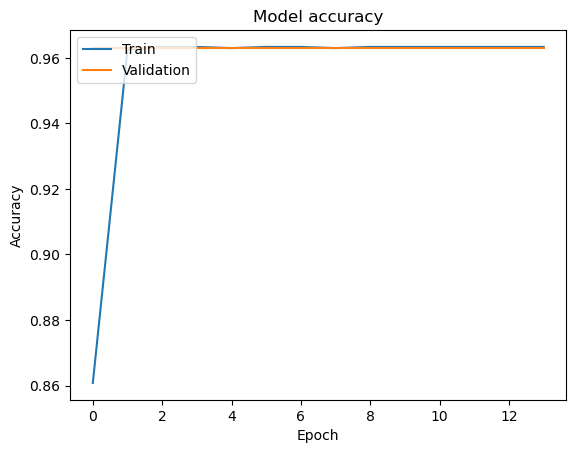

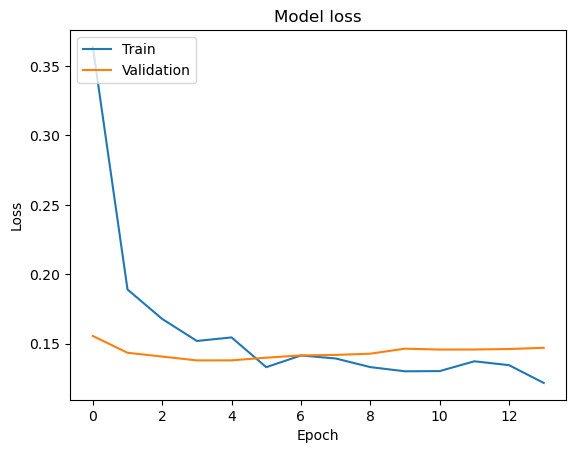

In [99]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [100]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

28/28 [==============================] - 0s 1ms/step


In [101]:
# Calculate model accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print model accuracy
print("Accuracy:", accuracy)

Accuracy: 0.958997722095672


### Plotting accuracy of all models

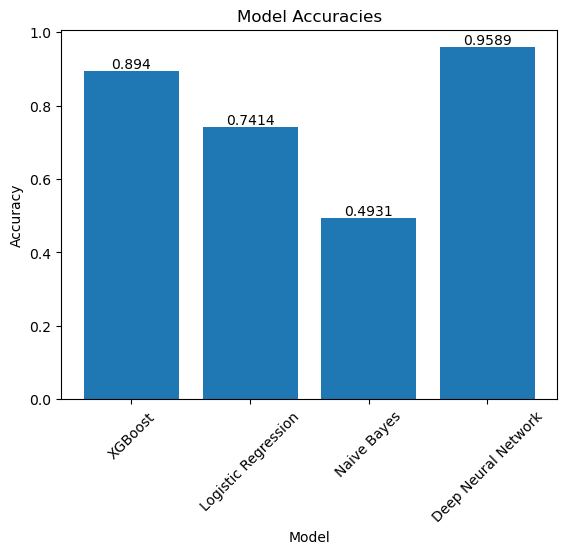

In [102]:
# Define the models and their accuracies
models = ['XGBoost', 'Logistic Regression', 'Naive Bayes', 'Deep Neural Network']
accuracies = [0.8940, 0.7414, 0.4931, 0.9589]

# Create a bar plot
plt.bar(models, accuracies)

# Set the title and axis labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)

# Add annotations to the bars
for i, v in enumerate(accuracies):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')


# Display the plot
plt.show()

We can clearly observe that XGBoost is a better algorithm compared to Logistic Regression and Naive Bayes algorithm; its accuracy and area-under-the-curve are higher. However, it does not outperform the accuracy level seen when implementing the Deep Neural Network model. However, we also acknowledge that further fine-tuning and optimization of the model may lead to even better performance.